# Library Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
!pip install sktime

     |████████████████████████████████| 9.5 MB 6.8 MB/s 


In [3]:
!pip install --upgrade numba

In [4]:
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sktime.classification.shapelet_based import MrSEQLClassifier

In [5]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Loading the Dataset

In [6]:
# load a single file
# and return it as an np array
def loadFile(path):
	df = pd.read_csv(path, header = None,
                  delim_whitespace = True) # entries separeted by spaces
	return df.values

In [7]:
# to load the train or test dataset X values
# into 3D np array with features as columns
def loadGroup(fileList, dirPath):
	group = []
	for f in fileList:
    # load the file
		data = loadFile(dirPath + f)
  
    # add it to the group
		group.append(data)
  
	# reshape to get features as innermost columns
	return np.dstack(group)

In [8]:
# group = "train" or "test"
def loadTrainOrTest(groupName, groupPath = ""):
  path = groupPath + groupName + '/Inertial Signals/'

  # list of files for the features
  suffix = groupName + ".txt"
  fileList = [
             'total_acc_x_'+ suffix, 
             'total_acc_y_' + suffix, 
             'total_acc_z_' + suffix,
             'body_acc_x_' + suffix, 
             'body_acc_y_' + suffix, 
             'body_acc_z_' + suffix,
             'body_gyro_x_' + suffix, 
             'body_gyro_y_' + suffix, 
             'body_gyro_z_' + suffix
             ]

  # loading the features
  X = loadGroup(fileList, path)
 
  # load the labels
  Y = loadFile(groupPath + groupName + '/y_'+ suffix)

  return X, Y

In [9]:
# loading the entire dataset
def loadAll(prefix=''):
  # load the training data
  Xtrain, Ytrain = loadTrainOrTest('train', prefix + 'UCI HAR Dataset/')

  # load all test
  Xtest, Ytest = loadTrainOrTest('test', prefix + 'UCI HAR Dataset/')
  
  # print(trainX.shape, trainy.shape, testX.shape, testy.shape)
  return Xtrain, Ytrain, Xtest, Ytest

In [10]:
Xtrain, Ytrain, Xtest, Ytest = loadAll("/content/drive/MyDrive/UCI_HAR_Dataset/")

# Data Preprocessing

In [11]:
# swapping axes for subsequent conversion
# to nested dataframes
arrTrain, arrTest = Xtrain.swapaxes(1, 2), Xtest.swapaxes(1, 2)

In [12]:
# column names
colNames = ["Tot Acc X", "Tot Acc Y", "Tot Acc Z",
            "Body Acc X", "Body Acc Y", "Body Acc Z",
            "Body Gyro X", "Body Gyro Y", "Body Gyro Z"]

In [13]:
# nested dataframe for training data
nestedTrain = from_3d_numpy_to_nested(arrTrain, column_names = colNames)
print(nestedTrain.shape)
nestedTrain.head()

(7352, 9)


,Tot Acc X,Tot Acc Y,Tot Acc Z,Body Acc X,Body Acc Y,Body Acc Z,Body Gyro X,Body Gyro Y,Body Gyro Z
0,0 1.012817 1 1.022833 2 1.02202...,0 -0.123217 1 -0.126876 2 -0.12400...,0 0.102934 1 0.105687 2 0.10210...,0 0.000181 1 0.010139 2 0.00927...,0 0.010767 1 0.006579 2 0.00892...,0 0.055561 1 0.055125 2 0.04840...,0 0.030191 1 0.043711 2 0.03568...,0 0.066014 1 0.042699 2 0.07485...,0 0.022859 1 0.010316 2 0.01325...
1,0 1.018851 1 1.022380 2 1.02078...,0 -0.123976 1 -0.126808 2 -0.12778...,0 0.097930 1 0.099351 2 0.09811...,0 0.001094 1 0.004550 2 0.00287...,0 -0.004688 1 -0.007488 2 -0.00843...,0 -0.026860 1 -0.025098 2 -0.02597...,0 0.017111 1 0.024179 2 0.03022...,0 0.006123 1 0.009710 2 0.01032...,0 0.012268 1 0.016150 2 0.01589...
2,0 1.023127 1 1.021882 2 1.01917...,0 -0.120016 1 -0.121499 2 -0.12284...,0 0.091117 1 0.092676 2 0.09606...,0 0.003531 1 0.002285 2 -0.00042...,0 0.004456 1 0.003046 2 0.00177...,0 -0.005915 1 -0.004139 2 -0.00054...,0 0.026189 1 0.021651 2 0.01455...,0 -0.000238 1 -0.000428 2 0.00076...,0 0.002159 1 -0.000272 2 0.00263...
3,0 1.017682 1 1.018149 2 1.01985...,0 -0.133404 1 -0.134364 2 -0.13520...,0 0.095152 1 0.095415 2 0.08827...,0 -0.001772 1 -0.001311 2 0.00038...,0 -0.010185 1 -0.011253 2 -0.01219...,0 0.001053 1 0.001227 2 -0.00600...,0 -0.037516 1 -0.033097 2 -0.03036...,0 -0.012886 1 -0.016918 2 -0.01618...,0 -0.000873 1 -0.005482 2 -0.00467...
4,0 1.019952 1 1.019616 2 1.02093...,0 -0.128731 1 -0.127846 2 -0.12823...,0 0.080841 1 0.079127 2 0.07829...,0 0.000087 1 -0.000272 2 0.00102...,0 -0.003857 1 -0.002838 2 -0.00308...,0 -0.013333 1 -0.014948 2 -0.01567...,0 -0.019429 1 -0.019091 2 -0.01481...,0 -0.008612 1 -0.008147 2 -0.00537...,0 -0.001574 1 0.000201 2 -0.00097...


In [14]:
# nested dataframe for training data
nestedTest = from_3d_numpy_to_nested(arrTest, column_names = colNames)
print(nestedTest.shape)
nestedTest.head()

(2947, 9)


,Tot Acc X,Tot Acc Y,Tot Acc Z,Body Acc X,Body Acc Y,Body Acc Z,Body Gyro X,Body Gyro Y,Body Gyro Z
0,0 1.041216 1 1.041803 2 1.03908...,0 -0.269796 1 -0.280025 2 -0.29266...,0 0.023780 1 0.076293 2 0.14747...,0 0.011653 1 0.013109 2 0.01126...,0 -0.029399 1 -0.039729 2 -0.05240...,0 0.106826 1 0.152455 2 0.21684...,0 0.437464 1 0.468264 2 0.49825...,0 0.531349 1 0.721069 2 0.52032...,0 0.136528 1 0.097622 2 0.08355...
1,0 0.999192 1 0.994679 2 0.99355...,0 -0.264935 1 -0.253214 2 -0.25658...,0 0.125616 1 0.125625 2 0.11638...,0 0.009280 1 0.004930 2 0.00395...,0 0.006651 1 0.018650 2 0.01553...,0 -0.026319 1 -0.026888 2 -0.03663...,0 0.170288 1 0.175222 2 0.13086...,0 -0.061374 1 -0.095364 2 -0.14645...,0 0.055096 1 0.043344 2 0.05239...
2,0 0.997593 1 0.998970 2 0.99705...,0 -0.263991 1 -0.263819 2 -0.26385...,0 0.150774 1 0.153943 2 0.14415...,0 0.005732 1 0.007066 2 0.00511...,0 0.007305 1 0.007331 2 0.00715...,0 0.010213 1 0.013414 2 0.00364...,0 -0.038726 1 -0.047282 2 -0.05390...,0 -0.060250 1 -0.051756 2 -0.05042...,0 0.029289 1 0.025366 2 0.02482...
3,0 0.994564 1 0.994727 2 0.99164...,0 -0.290593 1 -0.288886 2 -0.27398...,0 0.111199 1 0.115503 2 0.13525...,0 0.000452 1 0.000604 2 -0.00248...,0 -0.023806 1 -0.022051 2 -0.00710...,0 -0.027002 1 -0.022548 2 -0.00264...,0 -0.010128 1 0.003564 2 -0.00847...,0 0.003590 1 0.024609 2 0.02271...,0 0.008403 1 -0.009533 2 0.00177...
4,0 0.988150 1 0.989711 2 0.98753...,0 -0.283896 1 -0.283235 2 -0.28147...,0 0.133833 1 0.138512 2 0.13943...,0 -0.004362 1 -0.002765 2 -0.00490...,0 -0.009465 1 -0.008671 2 -0.00677...,0 -0.001461 1 0.003182 2 0.00406...,0 -0.036665 1 -0.040277 2 -0.03995...,0 -0.032427 1 -0.037960 2 -0.04271...,0 0.013983 1 0.020535 2 0.02336...


In [15]:
# sktime needs ravelled 1d arrays
arrYtrain, arrYtest = Ytrain.ravel() - 1, Ytest.ravel() - 1

In [16]:
print(arrYtrain.shape)
print(arrYtest.shape)

(7352,)
(2947,)


# Classification with MiniRocket + Linear Classifier

In [17]:
# defining the minirocket transformer
miniRocketTrans = MiniRocketMultivariate()

In [18]:
# fiting to the data
miniRocketTrans.fit(nestedTrain)

MiniRocketMultivariate()

In [19]:
# transforming the test and train inputs
nestedTrainTrans = miniRocketTrans.transform(nestedTrain)
nestedTestTrans = miniRocketTrans.transform(nestedTest)

In [20]:
nestedTestTrans

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9956,9957,9958,9959,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995
0,0.171875,0.976562,0.015625,0.835938,0.976562,0.085938,0.929688,0.000000,0.195312,0.976562,0.023438,0.875000,0.976562,0.125000,0.968750,0.007812,0.593750,0.976562,0.070312,0.906250,0.000000,0.171875,0.976562,0.015625,0.875000,0.976562,0.101562,0.945312,0.007812,0.351562,0.783333,0.250000,0.533333,1.0,0.341667,0.675000,0.116667,0.458333,0.833333,0.283333,...,0.015625,0.000,1.0,0.000,0.570312,0.437500,0.515625,1.000,0.000,1.000,0.000000,0.531250,1.000000,0.000,0.00,1.000,0.015625,0.890625,0.000000,0.000,1.00,0.000,0.648438,0.000000,0.468750,1.000,0.000,1.000,0.882812,0.312500,0.750000,0.000,0.500,1.000,0.437500,0.554688,0.648438,0.000,1.0,0.000
1,0.054688,0.976562,0.015625,0.890625,0.984375,0.039062,0.937500,0.000000,0.062500,0.976562,0.015625,0.921875,0.992188,0.039062,0.976562,0.015625,0.476562,0.976562,0.031250,0.937500,0.000000,0.054688,0.976562,0.015625,0.921875,0.992188,0.039062,0.953125,0.007812,0.187500,0.875000,0.183333,0.700000,1.0,0.358333,0.816667,0.083333,0.591667,0.925000,0.250000,...,0.000000,0.125,1.0,0.000,0.406250,0.398438,0.406250,1.000,0.000,1.000,0.000000,0.507812,1.000000,0.000,0.00,0.375,0.000000,1.000000,0.000000,0.000,1.00,0.000,0.648438,0.000000,0.468750,1.000,0.000,1.000,1.000000,0.351562,0.765625,0.000,0.000,1.000,0.351562,0.531250,0.554688,0.000,1.0,0.000
2,0.031250,0.976562,0.015625,0.960938,0.984375,0.023438,0.968750,0.000000,0.039062,0.976562,0.015625,0.968750,0.992188,0.023438,0.968750,0.007812,0.476562,0.976562,0.023438,0.968750,0.000000,0.031250,0.976562,0.015625,0.968750,0.984375,0.023438,0.968750,0.007812,0.140625,0.900000,0.183333,0.725000,1.0,0.383333,0.858333,0.100000,0.583333,0.941667,0.258333,...,0.000000,0.250,1.0,0.000,0.492188,0.375000,0.453125,1.000,0.000,1.000,0.000000,0.375000,1.000000,0.000,0.75,1.000,0.000000,1.000000,0.000000,1.000,1.00,0.000,0.648438,0.000000,0.468750,1.000,0.000,1.000,1.000000,0.390625,0.765625,0.000,0.000,1.000,0.375000,0.531250,0.648438,0.000,1.0,0.000
3,0.031250,0.968750,0.015625,0.945312,0.976562,0.023438,0.968750,0.000000,0.039062,0.976562,0.015625,0.968750,0.992188,0.023438,0.968750,0.015625,0.460938,0.976562,0.023438,0.968750,0.000000,0.031250,0.976562,0.015625,0.968750,0.984375,0.023438,0.968750,0.007812,0.125000,0.916667,0.216667,0.658333,1.0,0.350000,0.841667,0.091667,0.516667,0.941667,0.266667,...,0.000000,0.000,1.0,0.000,0.328125,0.195312,0.242188,1.000,0.000,1.000,0.000000,0.242188,1.000000,0.000,0.00,1.000,0.000000,1.000000,0.000000,0.000,1.00,0.000,0.648438,0.000000,0.468750,1.000,0.000,1.000,1.000000,0.343750,0.765625,0.000,0.250,1.000,0.351562,0.531250,0.640625,0.000,1.0,0.000
4,0.031250,0.976562,0.015625,0.906250,0.984375,0.023438,0.968750,0.000000,0.031250,0.976562,0.015625,0.968750,0.992188,0.023438,0.968750,0.015625,0.398438,0.976562,0.023438,0.968750,0.000000,0.031250,0.976562,0.015625,0.968750,0.984375,0.023438,0.968750,0.007812,0.109375,0.908333,0.216667,0.591667,1.0,0.341667,0.775000,0.091667,0.491667,0.933333,0.266667,...,0.000000,0.000,1.0,0.000,0.500000,0.242188,0.375000,1.000,0.875,1.000,0.000000,0.304688,1.000000,0.000,1.00,1.000,0.000000,1.000000,0.000000,1.000,1.00,0.000,0.648438,0.000000,0.468750,1.000,0.000,1.000,1.000000,0.351562,0.765625,0.000,0.375,1.000,0.351562,0.531250,0.648438,0.000,1.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,0.335938,0.796875,0.117188,0.515625,0.898438,0.242188,0.703125,0.062500,0.367188,0.851562,0.

In [21]:
# linear classifier definition
linearModel = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)

In [22]:
# training the linear classifier
linearModel.fit(nestedTrainTrans, arrYtrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [23]:
# making predictions
arrYpred = linearModel.predict(nestedTestTrans)

In [24]:
# model evaluation
print("accuracy of the Classifier = {}".format(accuracy_score(arrYtest, arrYpred)))
print(classification_report(arrYtest, arrYpred))

accuracy of the Classifier = 0.9731930777061418
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       1.00      1.00      1.00       471
           2       1.00      1.00      1.00       420
           3       0.95      0.89      0.92       491
           4       0.90      0.95      0.93       532
           5       1.00      1.00      1.00       537

    accuracy                           0.97      2947
   macro avg       0.98      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



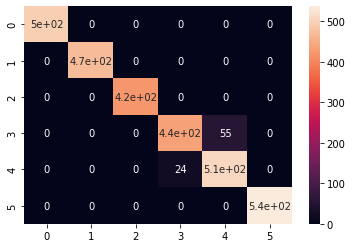

In [25]:
# confusion matrix
cfm = confusion_matrix(arrYtest, arrYpred)
sns.heatmap(cfm, annot = True)

# LSTM RNN

In [26]:
# one-hot encoding of labels
Ytrain = keras.utils.np_utils.to_categorical(Ytrain - 1)
Ytest = keras.utils.np_utils.to_categorical(Ytest - 1)

In [27]:
print(Ytrain.shape)
print(Ytest.shape)

(7352, 6)
(2947, 6)


In [28]:
Ytest

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [29]:
numTimesteps = Xtrain.shape[1] 
numFeatures = Xtrain.shape[2]
numOutputs = Ytrain.shape[1]
print(numTimesteps, numFeatures, numOutputs)

128 9 6


In [37]:
# defining the model
model = keras.Sequential([
                          keras.layers.LSTM(100, input_shape=(numTimesteps, numFeatures)),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(100, activation = "relu"),
                          keras.layers.Dense(numOutputs, activation = "softmax")
])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               44000     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 54,706
Trainable params: 54,706
Non-trainable params: 0
_________________________________________________________________


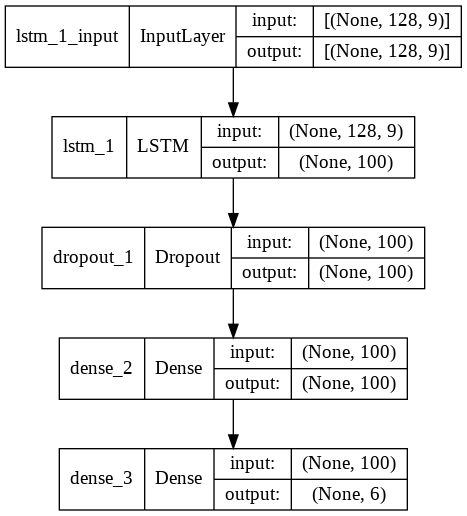

In [39]:
keras.utils.vis_utils.plot_model(model, show_shapes = True)

In [40]:
# compiling the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [41]:
EPOCHS = 20

In [42]:
# training the model
history = model.fit(Xtrain, Ytrain, 
          epochs = EPOCHS, 
          batch_size = 64,
          validation_data=(Xtest, Ytest)
          )

Epoch 1/20
115/115 [==============================] - 17s 133ms/step - loss: 1.1706 - accuracy: 0.5103 - val_loss: 1.0321 - val_accuracy: 0.5755
Epoch 2/20
115/115 [==============================] - 14s 123ms/step - loss: 0.7106 - accuracy: 0.6921 - val_loss: 0.7080 - val_accuracy: 0.7313
Epoch 3/20
115/115 [==============================] - 14s 124ms/step - loss: 0.5015 - accuracy: 0.7990 - val_loss: 0.6174 - val_accuracy: 0.7872
Epoch 4/20
115/115 [==============================] - 14s 122ms/step - loss: 0.3203 - accuracy: 0.8885 - val_loss: 0.4875 - val_accuracy: 0.8602
Epoch 5/20
115/115 [==============================] - 14s 124ms/step - loss: 0.2081 - accuracy: 0.9221 - val_loss: 0.3947 - val_accuracy: 0.8561
Epoch 6/20
115/115 [==============================] - 14s 122ms/step - loss: 0.1719 - accuracy: 0.9320 - val_loss: 0.5540 - val_accuracy: 0.8086
Epoch 7/20
115/115 [==============================] - 14s 124ms/step - loss: 0.1605 - accuracy: 0.9362 - val_loss: 0.3740 - val_ac

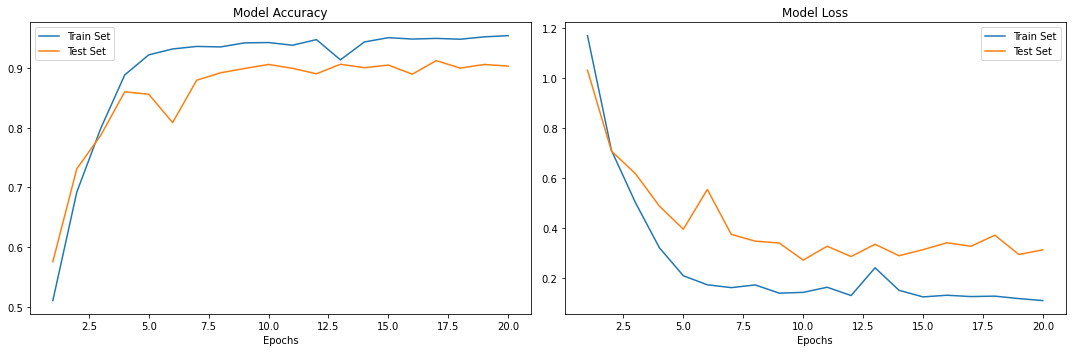

In [43]:
# plotting training loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [44]:
loss, accuracy = model.evaluate(Xtest, Ytest, 
                                batch_size = 64)

47/47 [==============================] - 2s 40ms/step - loss: 0.3121 - accuracy: 0.9033


In [45]:
# making an array of predictions
Ypred = np.argmax(model.predict(Xtest), axis = 1)

In [46]:
Ytest = np.argmax(Ytest, axis = 1)

In [47]:
# model evaluation
print("accuracy of MrSEQL = {}".format(accuracy_score(Ytest, Ypred)))
print(classification_report(Ytest, Ypred))

accuracy of MrSEQL = 0.9032914828639295
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       496
           1       0.90      0.97      0.94       471
           2       0.92      0.97      0.95       420
           3       0.81      0.79      0.80       491
           4       0.85      0.82      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.91      0.90      2947
weighted avg       0.90      0.90      0.90      2947



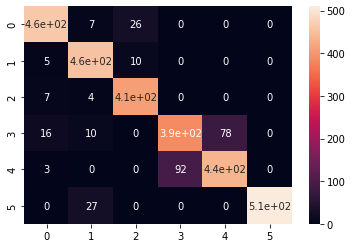

In [48]:
# confusion matrix
cfm = confusion_matrix(Ytest, Ypred)
sns.heatmap(cfm, annot = True)